In [133]:
%load_ext autoreload
%autoreload 2

import os
import itertools
import utils
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm

from utils import plot_domain, plot_measure, send_zero_transparent
from scenarios.congestion import prox_operator

print(os.getcwd())

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams["savefig.dpi"] = 160
plt.rcParams['text.usetex'] = True 

from scipy.stats import norm
from scipy.spatial import distance

from typing import List

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/manifold/Documents/pyprojects/mva-optimaltransport/project


# Full MFG entropic transport algorithm

## Setup

$\newcommand{\NN}{\mathbb N}$
$\newcommand{\RR}{\mathbb R}$
$\newcommand{\dif}{\mathrm{d}}$
$\renewcommand{\epsilon}{\varepsilon}$
$\renewcommand{\phi}{\varphi}$
$\newcommand{\suchthat}{\mathrm{s.t.}}$
$$
\DeclareMathOperator{\supp}{supp}
\DeclareMathOperator*{\argmin}{argmin}
\DeclareMathOperator*{\argmax}{argmax}
$$
$\newcommand{\bfR}{\mathbf R}$
$\newcommand{\bfP}{\mathbf P}$
$\DeclareMathOperator{\divg}{div}$
$\DeclareMathOperator{\supp}{supp}$
$\DeclareMathOperator{\KL}{KL}$
$\DeclareMathOperator{\prox}{prox}$

Number of grid points:  10201


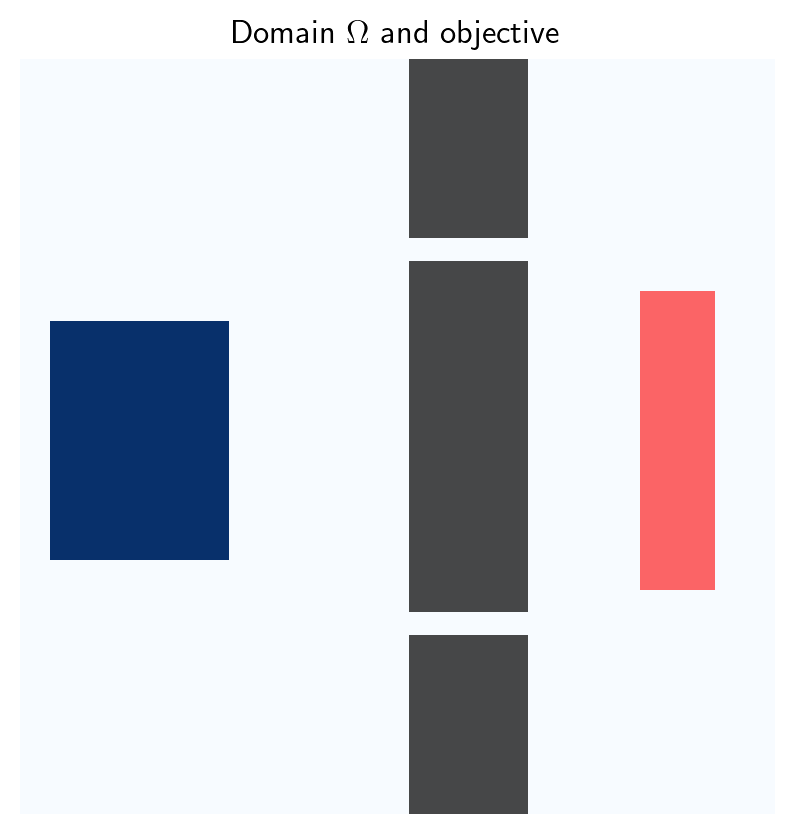

In [135]:
# Obstacle domain
from utils.rooms import room1, room2, room3
from utils.rooms import setup1, setup2, setup3


nx = 101
xar = np.linspace(0, 1, nx)
dx = xar[1] - xar[0]
ny = 101
yar = np.linspace(0, 1, ny)
dy = yar[1] - yar[0]
xg, yg = np.meshgrid(xar, yar)
print("Number of grid points: ", xg.size)

extent = [0, xar.max(), 0, yar.max()]


IMAGE_DIR = "images/multimarg_room1/"
os.makedirs(IMAGE_DIR, exist_ok=True)

rho_0, mask, exit_mask = setup1(xg, yg)

domain_img = np.zeros((ny, nx, 4))
domain_img[mask, 3] = 1.

# Exit (target)

exit_layer = np.zeros((ny, nx, 4))
exit_layer[exit_mask, 0] = 1.
exit_layer[exit_mask, 3] = 1.

# Plot
fig = plt.figure()
plot_domain(domain_img, extent=extent)
plot_measure(rho_0, extent=extent, cmap=cm.Blues)
plot_domain(exit_layer, alpha=.6, extent=extent)
plt.title("Domain $\\Omega$ and objective")
plt.axis('image')
plt.axis('off');

In [136]:
fig.savefig(IMAGE_DIR+"room_setup.pdf", bbox_inches='tight')

In [137]:
from utils import fast_sweep

speed_field = np.ones((ny, nx))
speed_field[mask] = 1e3  # "Kill" walking through the obstacles

sweep_iters = 140

potential_new_ = fast_sweep(speed_field, dx, exit_mask,
                            sweep_iters)
beta = 1.
premul = 50
potential_new_ = premul * potential_new_ ** beta

print(dx == dy)

True


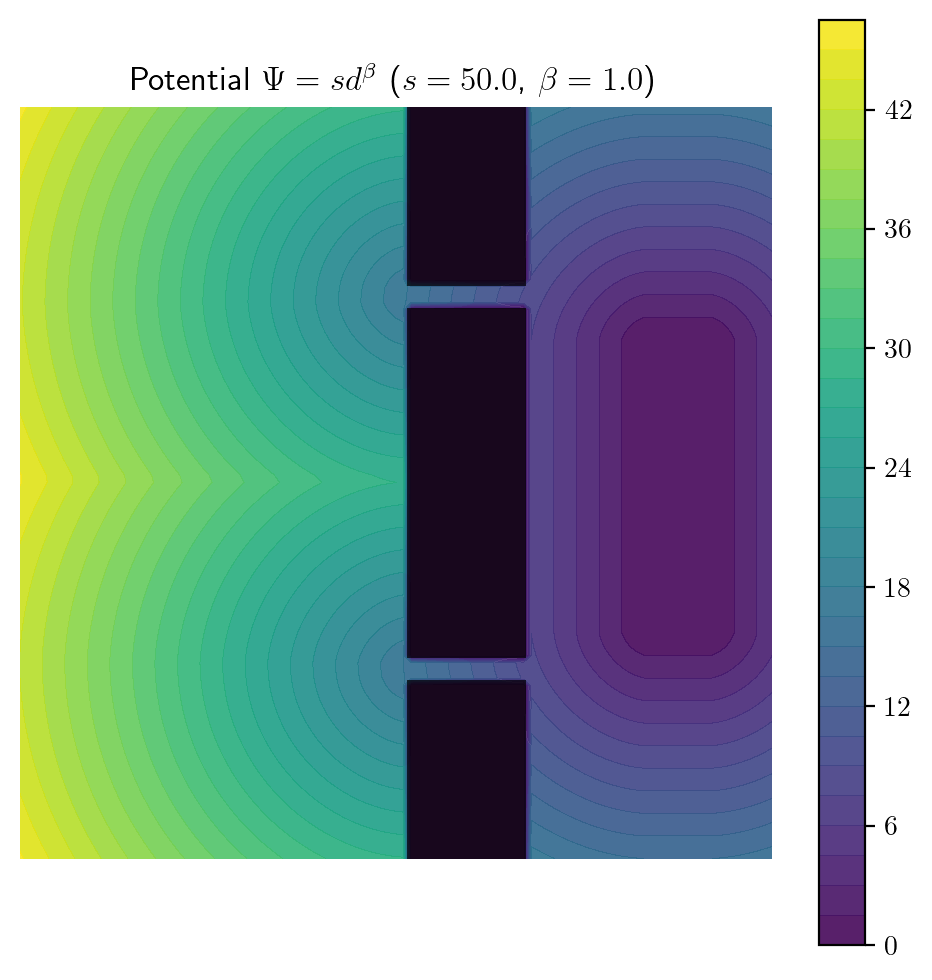

In [138]:
alphm = .9

fig = plt.figure()
ax = fig.add_subplot()
im_ = ax.contourf((1-mask)*potential_new_,
                  extent=extent, alpha=alphm, levels=40)
#im_ = plot_measure((1-mask) * potential_new_, extent=extent, alpha=alphm, cmap=cm.viridis)
plot_domain(domain_img, extent=extent)
#plot_domain(exit_layer, alpha=.3)

ax.set_title("Potential $\\Psi = sd^\\beta$ ($s=%.1f$, $\\beta=%.1f$)" 
             % (premul, beta))
#ax.set_aspect('auto')
fig.colorbar(im_)
plt.axis('off');
plt.tight_layout();

In [139]:
fig.savefig(IMAGE_DIR+"room_potential.pdf", bbox_inches='tight')

## Computation

The full transport problem is
$$
    \inf_\gamma \epsilon H(\gamma, \bfR) + h\sum_{k=1}^N F(\rho_k) + G(\rho_N)
$$
under the constraints $P^k_\#\gamma = \rho_k$.

In [154]:
# x-direction kernel
cost_mat1 = distance.cdist(
    xar[:, None], xar[:, None])  # distance between 1st-coordinates
cost_mat2 = distance.cdist(
    yar[:, None], yar[:, None])  # distance between 1st-coordinates

from contraction import FactoredKernel

N_t = 30
tmax = 20.
dt = tmax / N_t  # timestep

sigma = 0.04
epsilon = sigma ** 2
print("Epsilon:", epsilon)
print("tmax:", tmax)
print("dt:", dt)
## New epsilon-kernel
K1_eps = norm.pdf(cost_mat1, scale=sigma * dt ** .5)
K2_eps = norm.pdf(cost_mat2, scale=sigma * dt ** .5)

K_eps_op = FactoredKernel(K1_eps, K2_eps)

Epsilon: 0.0016
tmax: 20.0
dt: 0.6666666666666666


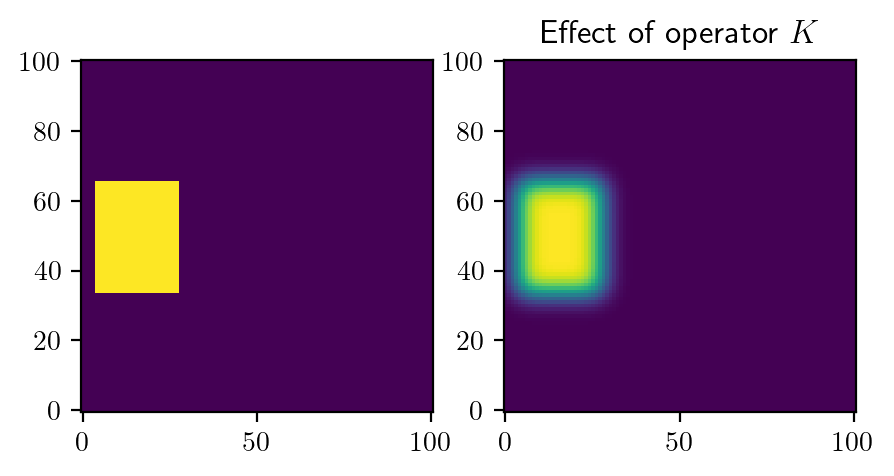

In [155]:
plt.subplot(1,2,1)
plt.imshow(rho_0, origin='lower')
plt.subplot(1,2,2)
plt.title("Effect of operator $K$")
plt.imshow(K_eps_op(rho_0), origin='lower')

The kernel is
$$
    \bfP_{i,j} = P_{h\epsilon}(x_j - x_i).
$$

Let's write the full Sinkhorn algorithm:

We get the marginals from
$$
    \rho_k^* = a_k^* \odot \mathbf{R}[(a^*_j)_{j\neq k}]
$$

In [156]:
from contraction import compute_message, compute_marginals
from scenarios.congestion import multi_sinkhorn

from utils.metrics import hilbert_metric_chained

import time
import copy

In [157]:
kappa = 1.0
congest_max = kappa * rho_0.max()
print("Max congestion:", congest_max)

Max congestion: 0.0013020833333333333


In [158]:
a_s = [
    np.ones((ny, nx)) for _ in range(N_t + 1)
]

In [159]:
t_a = time.time()
num_iters = 400
hmetr_ = []

thresh_ = 1e-8

for n in range(num_iters):
    a_olds = copy.deepcopy(a_s)
    multi_sinkhorn(a_s, K_eps_op, rho_0, mask, congest_max, potential_new_)
    hmetr_.append(hilbert_metric_chained(a_s, a_olds))
    print("iteration #%d: %.2e"% (n, hmetr_[-1]), end="\r")
    if hmetr_[-1] <= thresh_:
        # Early stopping
        print()
        print("Hilbert metric below threshold -- stopping.")
        break
    
print("Elapsed time:", time.time() - t_a)

iteration #55: 5.47e-09
Hilbert metric below threshold -- stopping.
Elapsed time: 13.083173274993896


In [160]:
from utils.plotting import hilbert_plot

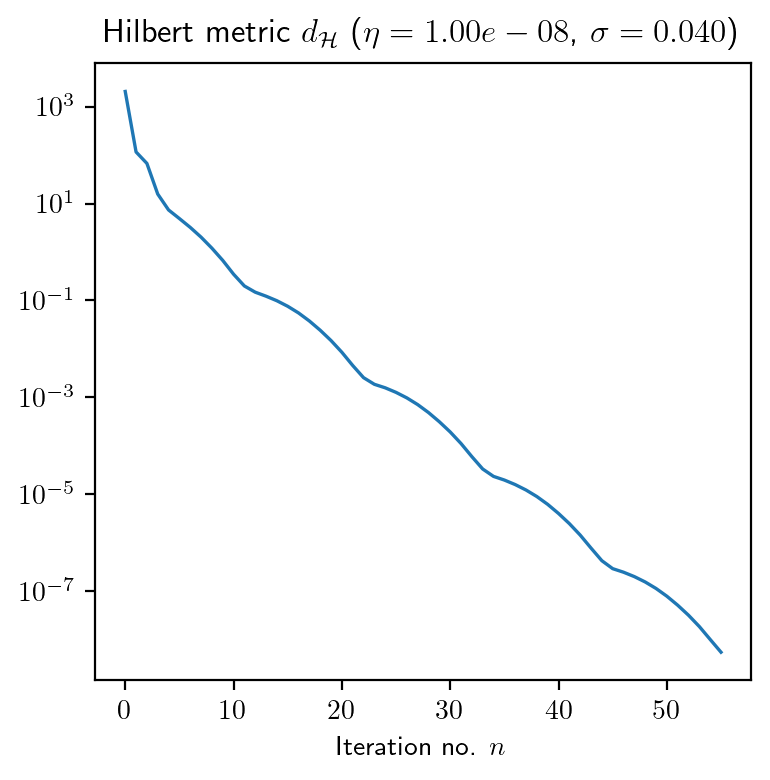

In [161]:
hmetr_ = np.array(hmetr_)
fig = hilbert_plot(hmetr_, thresh_, sigma)

fig.savefig(IMAGE_DIR+"hilbert_convergence.png")

In [162]:
# Now compute the marginals from the potentials
marginals = compute_marginals(a_s, K_eps_op)

print("Constraint rel. error:", np.abs(rho_0 - marginals[0]).max() / rho_0.max())

Constraint rel. error: 8.600237189071436e-11


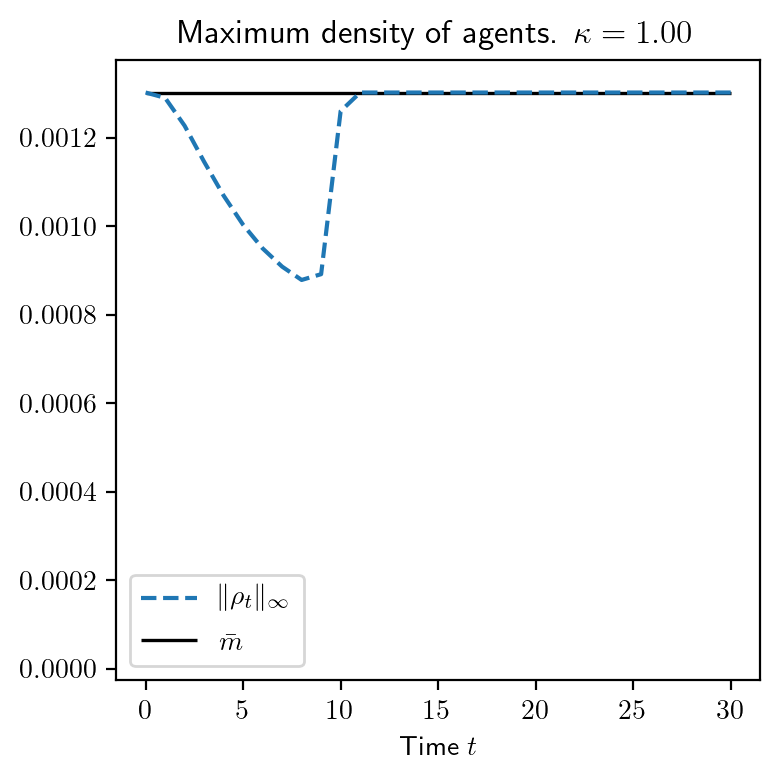

In [163]:
max_densities = []
for t, mu in enumerate(marginals):
    max_densities.append(mu.max())
    #print("Time %d: max density %.3e" % (t, mu.max()))
fig = plt.figure(figsize=(4,4))
plt.plot(max_densities, ls='--', label="$\|\\rho_t\|_\infty$")
plt.title("Maximum density of agents. $\kappa"+
          f"={kappa:.2f}$")
plt.hlines(congest_max, 0, N_t, ls='-',lw=1.2,label="$\\bar{m}$")
plt.legend()
ylims = plt.ylim()
plt.ylim((-.02*rho_0.max(), 1.04*ylims[1]))
plt.xlabel("Time $t$")
fig.tight_layout()

fig.savefig(IMAGE_DIR+"congestion_plot.pdf", bbox_inches='tight')

In [164]:
skip = 6
steps_to_plot = np.arange(N_t+1)[::skip]

print(steps_to_plot)
print("Plot",len(steps_to_plot), "steps.")
ncols = 3
nrows = len(steps_to_plot) // ncols
print("ncols:", ncols, "nrows:", nrows)

[ 0  6 12 18 24 30]
Plot 6 steps.
ncols: 3 nrows: 2


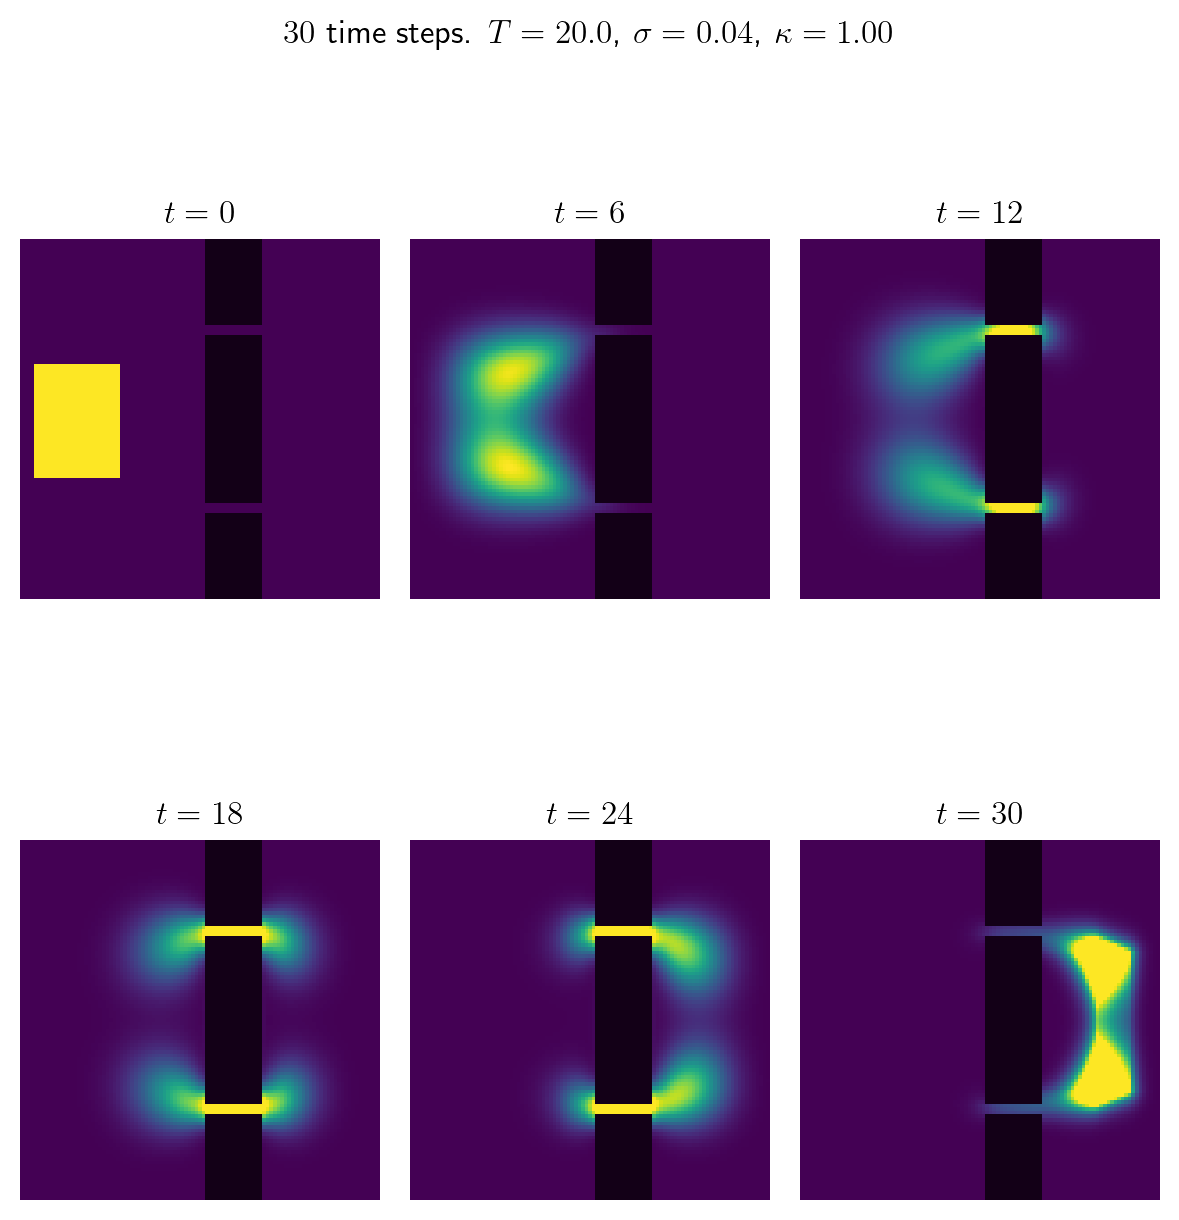

In [165]:
fig, axes = plt.subplots(nrows, ncols, figsize=(6, 7), dpi=100)
axes = axes.ravel()


for i, t in enumerate(steps_to_plot):
    if i < len(axes):
        ax = axes[i]
        t = steps_to_plot[i]
        mu = marginals[t]
        plot_domain(domain_img, cax=ax, extent=extent)
        plot_measure(mu, cax=ax, extent=extent, cmap=cm.viridis)
        ax.axis('off')
        ax.set_title("$t=%d$" % t)

title = ("$%d$ time steps. $T=%.1f$, $\\sigma=%.2f$, $\kappa" +
        f"={kappa:.2f}$")
fig.suptitle(title % (N_t, tmax, sigma), y=1.0)
fig.tight_layout();

In [132]:
fig.savefig(IMAGE_DIR+'multimarg_transport.pdf', bbox_inches='tight')